# **Modelling and Evaluation Notebook**

## Objectives

Answer business requirement 2 and 3:
- The client is interested to tell whether a given plant is Healthy or Powdery
- Provide recommendations for treating plants infected with powdery mildew

## Inputs

- inputs/datasets/cherry-leaves/train
- inputs/datasets/cherry-leaves/validation
- inputs/datasets/cherry-leaves/test
- image shape embeddings

## Outputs
- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file

### Additional Comments

Version 1 will be created and try different ways to fit the model to chose which has more accuracy


---
## **Prepare Data Directories**

#### Import libraries


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#### Change working directory

- Change the working directory from its current folder to its parent folder
- Access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

### Set input directories

Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

# Verify that the directories exist
for path in [train_path, val_path, test_path]:
    if not os.path.isdir(path):
        raise ValueError(f"Directory does not exist: {path}")


### Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version already exists, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version already exists, please create a new version.


### Set labels

In [8]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape

Import the image shape from the output folder using the library joblib


In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50, 3)

---

### **Number of images in train, test and validation data**

- Get the number of images in the train, validation and test datasets, and plot them
- To help visualize, we add the numbers into a dataframe and create a barplot

 train - healthy: 1472 images
 train - powdery_mildew: 1472 images
 validation - healthy: 210 images
 validation - powdery_mildew: 210 images
 test - healthy: 422 images
 test - powdery_mildew: 422 images




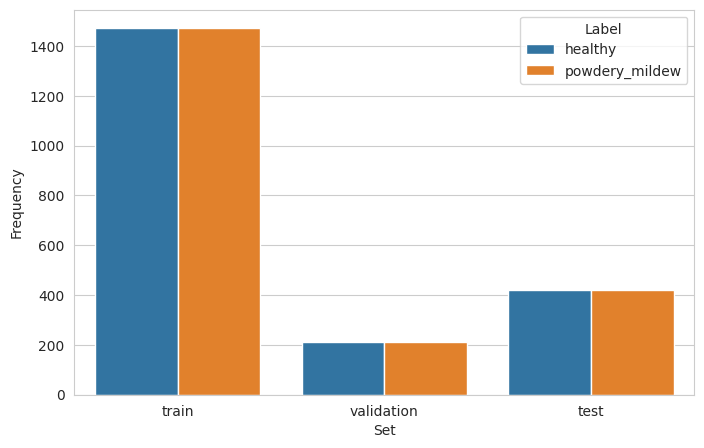

In [10]:
df_freq = pd.DataFrame([])
# Create a dataframe and append each folder to it, and for each of them, every
# label and its frequency.
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir+'/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f" {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
# Create the figure to plot the dataframe
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation

- Generate different images in the train set to use them during the training. We import the library ImageDataGenerator to do it. The images will be created in an artificial and temporarilly way, in RAM memory

- The ImageDataGenerator takes the images from the set and performs different operations like rotations, shifts, zooms and flips to effectively create "new" images that are added to the set. This way, the new images retain the original features, in this case the leaf shape, color and markings on the leaves, but have small variations in them.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


 Initialize ImagaDataGenerator


In [12]:

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augment training image dataset


In [13]:
# Set to generate 20 images for each image in the dataset, and save them as train_set variable
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

# Print out some information
print("Class indices:", train_set.class_indices)
print("Number of classes:", len(train_set.class_indices))
print("Number of samples:", train_set.samples)

Found 2944 images belonging to 2 classes.
Class indices: {'healthy': 0, 'powdery_mildew': 1}
Number of classes: 2
Number of samples: 2944


Augment validation image dataset

In [14]:
# Augmenting the validation images only by standardizing image pixels between 0 to 255
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment test image dataset


In [15]:
# Augmenting the test images only by standardizing image pixels between 0 to 255
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

- Plot some samples from the augmented images to check that we still see the relevant features

(20, 50, 50, 3)


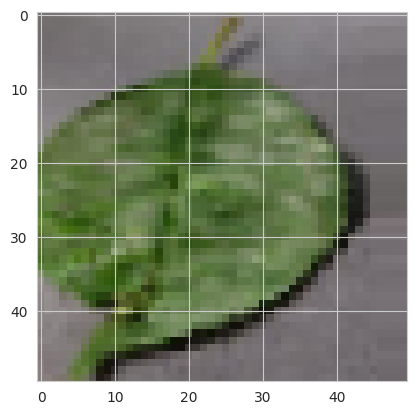

(20, 50, 50, 3)


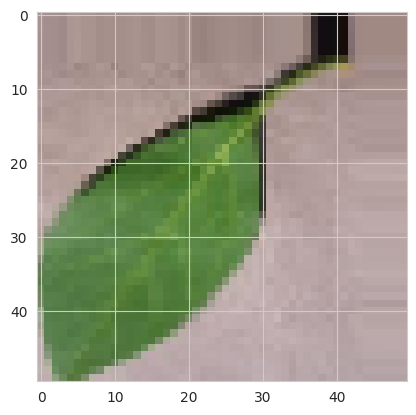

(20, 50, 50, 3)


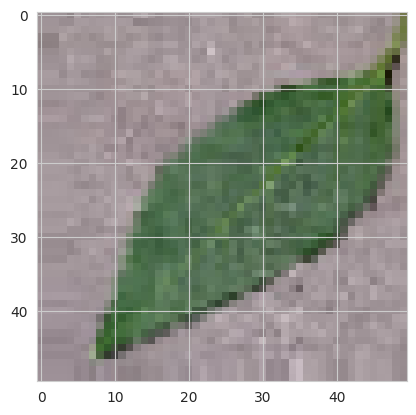

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images


(20, 50, 50, 3)


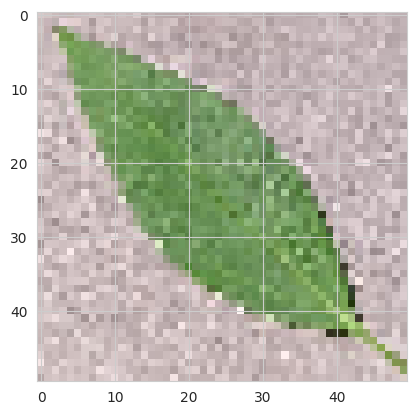

(20, 50, 50, 3)


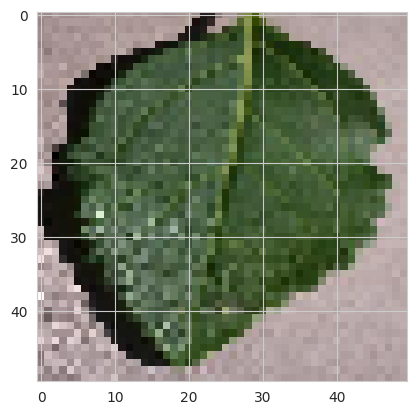

(20, 50, 50, 3)


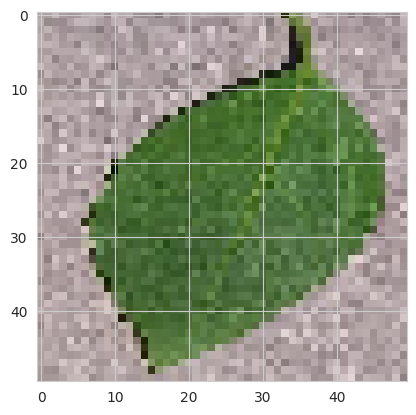

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 50, 50, 3)


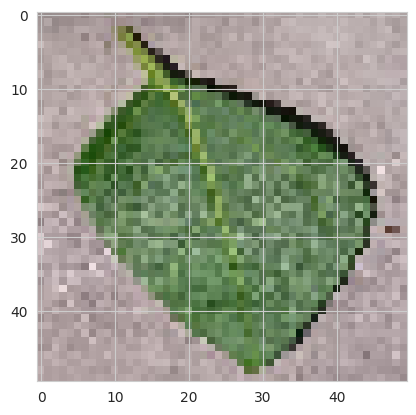

(20, 50, 50, 3)


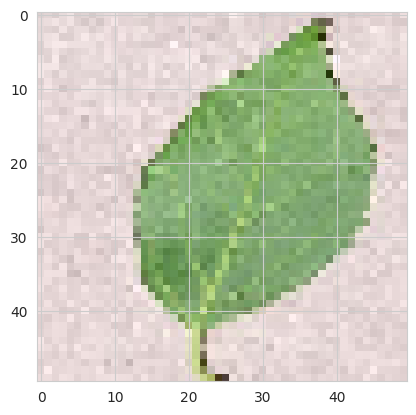

(20, 50, 50, 3)


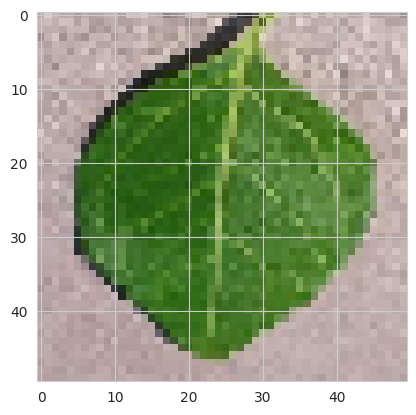

In [19]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Save class indices

And save the class indices as a .pkl file

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---
# **Model Creation**

## Base ML Model

- Importing model packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D


- As a base ML model, we go with a Convolutional Neural Network, using Tensorflow's Sequential model. 

In [24]:
def create_tf_model():
    """ Create the model with different layers and the optimizer, and try different filters,
        differetn numbers of layers and optimizers """
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                  metrics=['accuracy'])

    return model


### Model Summary

In [25]:
create_tf_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 64)         

### Early Stopping

- In order to not overfit the model, need to add a function to stop the training of the model early.



In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [27]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-08-19 22:11:27.457672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 12s 80ms/step - loss: 0.4061 - accuracy: 0.7886 - val_loss: 0.1558 - val_accuracy: 0.9405
Epoch 2/25
147/147 [==============================] - 11s 77ms/step - loss: 0.1455 - accuracy: 0.9460 - val_loss: 0.0737 - val_accuracy: 0.9810
Epoch 3/25
147/147 [==============================] - 11s 75ms/step - loss: 0.0884 - accuracy: 0.9699 - val_loss: 0.0489 - val_accuracy: 0.9881
Epoch 4/25
147/147 [==============================] - 11s 75ms/step - loss: 0.0514 - accuracy: 0.9822 - val_loss: 0.0521 - val_accuracy: 0.9881
Epoch 5/25
147/147 [==============================] - 11s 77ms/step - loss: 0.0351 - accuracy: 0.9878 - val_loss: 0.0286 - val_accuracy: 0.9881
Epoch 6/25
147/147 [==============================] - 11s 76ms/step - loss: 0.0262 - accuracy: 0.9921 - val_loss: 0.0114 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 11s 75ms/step - loss: 0.0331 - accuracy: 0.9904 - val_loss: 0.0356 - val_accuracy:

#### Save Model

In [30]:
model.save("outputs/v1/powdery_mildew_detector_model.h5")


## **Model Performance**

#### Model learning curve

- Function to show the learning curve of the model, to check if we have overfitting or underfitting.
- In an ideal model, the loss of the train set will tend to 0 and the accuracy of the train set will tend to 1, and the loss and accuracy of the validation set will have a very similar progression.




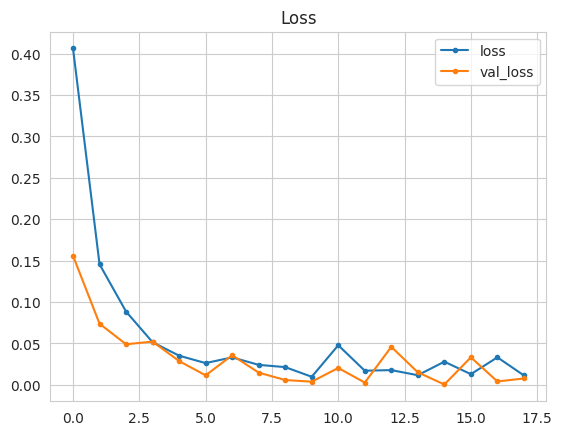

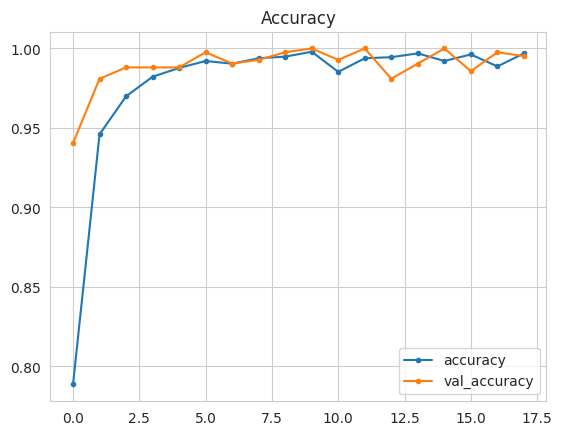

In [31]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


#### Model Evaluation

The absolute loss and accuracy of the model can be evaluated using the keras library, and it can be run on unseen data, i.e. our labelled test set.

In [32]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_detector_model.h5')

The model that was saved earlier is loaded:

In [34]:
evaluation = model.evaluate(test_set)

 5/43 [==>...........................] - ETA: 0s - loss: 2.8504e-07 - accuracy: 1.0000

43/43 [==============================] - 1s 19ms/step - loss: 0.0292 - accuracy: 0.9941


It is observed that the prediction accuracy of the model is at just over **99%**. The performance goal set by the client, which was at least 97% accuracy, is met by this result.

---
### **Prediction on New Data**

As a manual confirmation, it is attempted to determine if the prediction is accurate on any image that is loaded.
Any image from the test set is loaded (code has been adapted and adjusted from the CI Malaria walkthrough)

(1, 50, 50, 3)
Image shape: (50, 50)
Image mode: RGB
Predicted class: powdery_mildew
Prediction probabilities: 1.0000


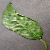

In [43]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select a powderly mildew infected image

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')

# Convert the image to an array to make the prediction
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255

# Predict class probablilities
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]


if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

# Display the prediction
print(f'Image shape: {pil_image.size}')
print(f'Image mode: {pil_image.mode}')
print(f'Predicted class: {pred_class}')
print(f'Prediction probabilities: {pred_proba:.4f}')

pil_image

## Conclusions and next steps

- Following multiple model iterations with varying setups, we finally choose the train number 3 to create the final model.
- It has six layers, drop percent of 0.5 in last layer to avoid overffiting, binary_crossentropy and adam as loss and optimizer hiperparameters respectively.
- Each of the tested configurations surpassed the project's requirement(at least 97% accuracy on test set).
- Moving forward, our next steps are to complete the dashboard development and proceed with application deployment.